## Setup

In [64]:
import json
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
with open("../intermediate_data/fire_features_with_distances.json", "r") as file:
    feature_list = json.load(file)

In [44]:
for feature in feature_list:
    feature["attributes"]["shortest_distance_to_pueblo"] = feature["attributes"]["shortest_distance_to_pueblo"][0]

In [46]:
import geopandas as gpd
from shapely.geometry import Polygon

def convert_to_geodataframe(feature_list):
    processed_features = []

    for i, feature in tqdm(enumerate(feature_list)):
        attributes = feature['attributes']
        geometry = feature.get('geometry')
        
        # some geometries are not rings; this can be problematic, so 
        # I add a check and log exceptions
        if geometry and 'rings' in geometry:
            try:
                polygon = Polygon(geometry['rings'][0])
                processed_features.append({**attributes, 'geometry': polygon})
            
            except Exception as e:
                print(f"Problem with geometry for OBJECTID {attributes.get('OBJECTID')}: {e}")
        
        elif geometry and 'curveRings'in geometry:
            try:
                polygon = Polygon(geometry['curveRings'][0])
                processed_features.append({**attributes, 'geometry': polygon})
            
            except Exception as e:
                print(f"Problem with geometry for OBJECTID {attributes.get('OBJECTID')}: {e}")
        else:
            print(f"Skipping feature with OBJECTID {attributes.get('OBJECTID')}: No 'rings' found. Instead, got: {geometry}\n")

    gdf = gpd.GeoDataFrame(processed_features, geometry='geometry')
    return gdf


In [47]:
gdf = convert_to_geodataframe(feature_list)

112015it [00:17, 11788.06it/s]

Problem with geometry for OBJECTID 109605: could not convert string to float: 'b'
Problem with geometry for OBJECTID 110224: could not convert string to float: 'a'
Problem with geometry for OBJECTID 110639: could not convert string to float: 'b'
Problem with geometry for OBJECTID 111431: could not convert string to float: 'a'
Problem with geometry for OBJECTID 111897: could not convert string to float: 'b'


114631it [00:17, 12384.30it/s]

Problem with geometry for OBJECTID 112410: could not convert string to float: 'a'
Problem with geometry for OBJECTID 112415: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113411: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113665: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113738: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113766: could not convert string to float: 'a'
Problem with geometry for OBJECTID 113805: could not convert string to float: 'a'
Problem with geometry for OBJECTID 114309: could not convert string to float: 'a'
Problem with geometry for OBJECTID 114322: could not convert string to float: 'a'


117375it [00:17, 13062.92it/s]

Problem with geometry for OBJECTID 115629: could not convert string to float: 'a'
Problem with geometry for OBJECTID 115974: could not convert string to float: 'a'
Problem with geometry for OBJECTID 116235: could not convert string to float: 'c'
Problem with geometry for OBJECTID 117086: could not convert string to float: 'a'


122235it [00:17, 15062.81it/s]

Problem with geometry for OBJECTID 119582: could not convert string to float: 'a'
Problem with geometry for OBJECTID 119617: could not convert string to float: 'a'
Problem with geometry for OBJECTID 119751: could not convert string to float: 'a'
Problem with geometry for OBJECTID 119982: could not convert string to float: 'a'
Problem with geometry for OBJECTID 120212: could not convert string to float: 'a'
Problem with geometry for OBJECTID 120678: could not convert string to float: 'a'
Problem with geometry for OBJECTID 121010: could not convert string to float: 'a'
Problem with geometry for OBJECTID 122264: could not convert string to float: 'a'


128239it [00:18, 14081.40it/s]

Problem with geometry for OBJECTID 125745: could not convert string to float: 'a'
Problem with geometry for OBJECTID 127492: could not convert string to float: 'a'


135061it [00:18, 7335.88it/s] 


## Data Exploration & Simplification

The section below documents my data exploration to figure out which columns to keep and drop. Please feel free to skip.

In [56]:
# print the columns of the dataframe to figure out 
gdf.columns

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'shortest_distance_to_pueblo', 'centroid_distance_to_pueblo',
       'geometry'],
      dtype='object')

In [57]:
columns_to_include = [
    "USGS_Assigned_ID",
    "Assigned_Fire_Type",
    "Fire_Year",
    "GIS_Acres",
    "Shape_Length",
    "Shape_Area",
    "shortest_distance_to_pueblo",
    "centroid_distance_to_pueblo",
    "geometry"
]

simplified_gdf = (gdf.
                  filter(columns_to_include))

In [58]:
DISTANCE_CUTOFF = 1800

fires_within_1800_mi = (
    simplified_gdf
    .pipe(lambda x: x[x['centroid_distance_to_pueblo'] <= DISTANCE_CUTOFF])
)

fires_within_1800_mi

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry
0,1,Wildfire,1860,3940.207089,64888.449849,1.594545e+07,1137.124505,1139.206473,"POLYGON ((-1883775.596 1194154.192, -1883782.4..."
1,2,Wildfire,1860,772.518249,23462.288613,3.126270e+06,1135.778280,1136.854043,"POLYGON ((-1887470.131 1187759.244, -1887546.2..."
2,3,Wildfire,1860,333.020409,6679.573569,1.347686e+06,1138.124278,1138.643550,"POLYGON ((-1889386.119 1190683.928, -1889454.1..."
3,4,Wildfire,1870,22294.993577,84700.719226,9.022464e+07,778.046670,781.198321,"POLYGON ((-1428896.297 864980.034, -1428690.21..."
4,5,Wildfire,1870,36.985574,2937.265383,1.496753e+05,637.107402,637.246282,"POLYGON ((-1371410.414 595942.396, -1371424.53..."
...,...,...,...,...,...,...,...,...,...
135028,135057,Prescribed Fire,2020,16.412148,2168.900740,6.641761e+04,1024.698218,1024.831573,"POLYGON ((-2008802.496 729335.562, -2008682.90..."
135029,135058,Prescribed Fire,2020,7.050837,978.666221,2.853373e+04,804.543266,804.651400,"POLYGON ((-1648510.319 666410.727, -1648817.72..."
135030,135059,Prescribed Fire,2020,9.342668,1958.326660,3.780843e+04,804.367278,804.416914,"POLYGON ((-1649244.566 664993.758, -1649215.60..."
135031,135060,Prescribed Fire,2020,0.996962,225.866452,4.034562e+03,276.836936,276.859208,"POLYGON ((-1017808.425 140344.112, -1017805.50..."


In [59]:
wildfires_within_1800_mi = (
    fires_within_1800_mi
    .pipe(lambda x: x[x["Assigned_Fire_Type"] == "Wildfire"])
)

wildfires_within_1800_mi

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry
0,1,Wildfire,1860,3940.207089,64888.449849,1.594545e+07,1137.124505,1139.206473,"POLYGON ((-1883775.596 1194154.192, -1883782.4..."
1,2,Wildfire,1860,772.518249,23462.288613,3.126270e+06,1135.778280,1136.854043,"POLYGON ((-1887470.131 1187759.244, -1887546.2..."
2,3,Wildfire,1860,333.020409,6679.573569,1.347686e+06,1138.124278,1138.643550,"POLYGON ((-1889386.119 1190683.928, -1889454.1..."
3,4,Wildfire,1870,22294.993577,84700.719226,9.022464e+07,778.046670,781.198321,"POLYGON ((-1428896.297 864980.034, -1428690.21..."
4,5,Wildfire,1870,36.985574,2937.265383,1.496753e+05,637.107402,637.246282,"POLYGON ((-1371410.414 595942.396, -1371424.53..."
...,...,...,...,...,...,...,...,...,...
125213,125240,Wildfire,2019,2707.972005,15247.605295,1.095877e+07,223.622700,225.558881,"POLYGON ((-1053400.695 -192307.078, -1053438.1..."
125366,125393,Wildfire,2019,2661.472459,51691.985678,1.077060e+07,1445.429250,1445.618420,"POLYGON ((1452467.255 -669594.579, 1452444.328..."
127198,127226,Wildfire,2020,471.592503,9578.493276,1.908467e+06,1011.320532,1012.089256,"POLYGON ((631347.374 -1020210.11, 632158.333 -..."
130435,130464,Wildfire,1987,16.673322,1201.447427,6.747454e+04,1045.019029,1045.118924,"POLYGON ((-2104386.345 613774.003, -2104493.80..."


In [61]:
YEAR_CUTOFF = 1961

close_wildfires_since1961 = (
    wildfires_within_1800_mi
    .pipe(lambda x: x[x["Fire_Year"] >= YEAR_CUTOFF])
)

close_wildfires_since1961

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry
13525,13526,Wildfire,1961,55249.740141,83939.248629,2.235878e+08,935.680525,941.760179,"POLYGON ((-2051345.981 326515.439, -2051248.52..."
13526,13527,Wildfire,1961,43920.841077,85648.862830,1.777413e+08,826.756406,827.402778,"POLYGON ((-1963786.858 -73308.684, -1963770.81..."
13527,13528,Wildfire,1961,34233.698603,73755.413582,1.385389e+08,870.213578,877.642104,"POLYGON ((-2010119.557 86591.889, -2009750.964..."
13528,13529,Wildfire,1961,32866.053451,58906.755757,1.330042e+08,917.867535,924.355356,"POLYGON ((-2109129.163 -37432.94, -2109476.915..."
13529,13530,Wildfire,1961,27269.045936,56575.916692,1.103539e+08,884.697857,888.488793,"POLYGON ((-1710951.52 804262.873, -1710910.802..."
...,...,...,...,...,...,...,...,...,...
125213,125240,Wildfire,2019,2707.972005,15247.605295,1.095877e+07,223.622700,225.558881,"POLYGON ((-1053400.695 -192307.078, -1053438.1..."
125366,125393,Wildfire,2019,2661.472459,51691.985678,1.077060e+07,1445.429250,1445.618420,"POLYGON ((1452467.255 -669594.579, 1452444.328..."
127198,127226,Wildfire,2020,471.592503,9578.493276,1.908467e+06,1011.320532,1012.089256,"POLYGON ((631347.374 -1020210.11, 632158.333 -..."
130435,130464,Wildfire,1987,16.673322,1201.447427,6.747454e+04,1045.019029,1045.118924,"POLYGON ((-2104386.345 613774.003, -2104493.80..."


## Defining the Smoke Estimate

How much smoke affects a point in space (in my case, Pueblo, CO) should increase with the acreage burned and decrease with the distance from the source. 

Already, this requires making a choice, since we have two notions of distance available in our data: do we use the centroid distance (Pueblo, CO to the centroid of the fire area) or the edge distance (Pueblo to the closest point in the fire area).

I hypothesized that it wouldn't make a big difference for most fires, since most fires aren't very large. To test this, I checked the data:

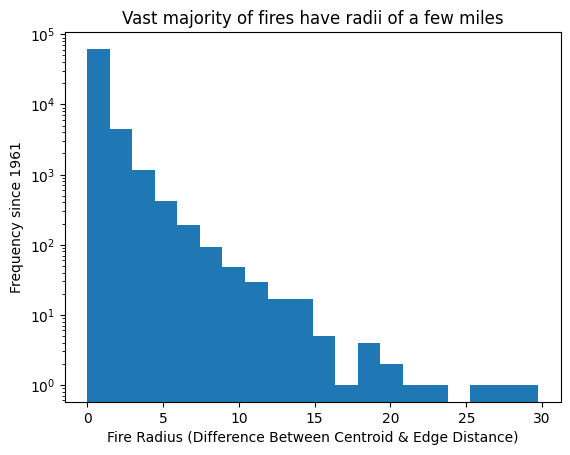

In [69]:
fire_radius = close_wildfires_since1961["centroid_distance_to_pueblo"] - close_wildfires_since1961["shortest_distance_to_pueblo"]

plt.hist(fire_radius, bins = 20)
plt.yscale("log")
plt.title("Vast majority of fires have radii of a few miles")
plt.xlabel("Fire Radius (Difference Between Centroid & Edge Distance)")
plt.ylabel("Frequency since 1961")
plt.show()

A few outlier fires have larger radii; most are small.

Therefore, to simplify modeling, I will use the **centroid distance**. This allows me to (simplistically) simulate the fire as coming from a point source, with all of the burning acreage coming from that point source.

Moreover, I will assume that the point source generates some volume of smoke, and that *on average* (across all wildfires since 1961) this smoke dissipates roughly equally in all directions. This is not completely because there are systematic factors (terrain, wind patterns) that mean smoke does not spread equally in all directions, but it is a reasonable first approximation for my purposes.

The assumption that smoke dissipates equally in all directions from the point source allows me to use an inverse-square law. At a given point in time, a constant volume of smoke emanating from the point-source fills a half-sphere around the point source with radius $r$, where $r$ indicates the furthest point the smoke has reached. I will call this the "smoke radius"

Imagine some point $d$ (like a city), inside of the smoke radius ($d < r$). The volume of smoke inside of that point (between $d$ and the point source of the smoke) is proportional to $d^2$. Therefore, the smoke density at point $d$ is *inversely* proportional to $d^2$.

Let $SIE$ indicate the Smoke Intensity Estimate. I want this to increase linearly with the acreage burned ($A$) and to be inversely proportional to the squared centroid distance $d$ between the city and the "point source" generating the smoke:

$$SIE \propto \frac{A}{d^2}$$

In the code below I implement this notion of smoke intensity. The units are irrelevant for my purposes, so I keep them as they are.

In [72]:
close_wildfires_since1961.loc[:,"smoke_intensity_est"] = (close_wildfires_since1961["GIS_Acres"] / 
                                                    ((close_wildfires_since1961["centroid_distance_to_pueblo"])**2))

close_wildfires_since1961

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,shortest_distance_to_pueblo,centroid_distance_to_pueblo,geometry,smoke_intensity_est
13525,13526,Wildfire,1961,55249.740141,83939.248629,2.235878e+08,935.680525,941.760179,"POLYGON ((-2051345.981 326515.439, -2051248.52...",0.062294
13526,13527,Wildfire,1961,43920.841077,85648.862830,1.777413e+08,826.756406,827.402778,"POLYGON ((-1963786.858 -73308.684, -1963770.81...",0.064156
13527,13528,Wildfire,1961,34233.698603,73755.413582,1.385389e+08,870.213578,877.642104,"POLYGON ((-2010119.557 86591.889, -2009750.964...",0.044445
13528,13529,Wildfire,1961,32866.053451,58906.755757,1.330042e+08,917.867535,924.355356,"POLYGON ((-2109129.163 -37432.94, -2109476.915...",0.038465
13529,13530,Wildfire,1961,27269.045936,56575.916692,1.103539e+08,884.697857,888.488793,"POLYGON ((-1710951.52 804262.873, -1710910.802...",0.034543
...,...,...,...,...,...,...,...,...,...,...
125213,125240,Wildfire,2019,2707.972005,15247.605295,1.095877e+07,223.622700,225.558881,"POLYGON ((-1053400.695 -192307.078, -1053438.1...",0.053226
125366,125393,Wildfire,2019,2661.472459,51691.985678,1.077060e+07,1445.429250,1445.618420,"POLYGON ((1452467.255 -669594.579, 1452444.328...",0.001274
127198,127226,Wildfire,2020,471.592503,9578.493276,1.908467e+06,1011.320532,1012.089256,"POLYGON ((631347.374 -1020210.11, 632158.333 -...",0.000460
130435,130464,Wildfire,1987,16.673322,1201.447427,6.747454e+04,1045.019029,1045.118924,"POLYGON ((-2104386.345 613774.003, -2104493.80...",0.000015


In [75]:
close_wildfires_since1961["smoke_intensity_est"].describe()

count    6.841600e+04
mean     1.540989e-02
std      5.137532e-01
min      1.157996e-14
25%      1.063996e-05
50%      1.395730e-04
75%      1.249019e-03
max      9.130211e+01
Name: smoke_intensity_est, dtype: float64

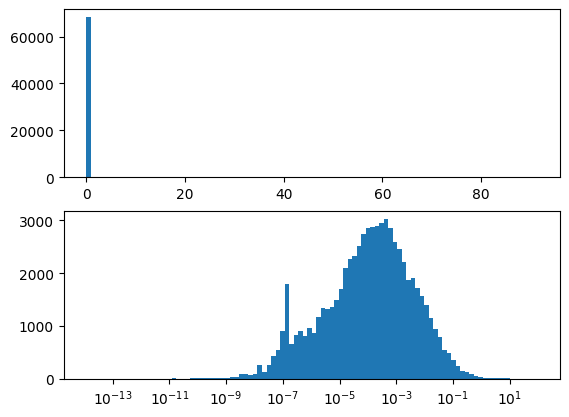

In [82]:
import pandas as pd

x = pd.Series(close_wildfires_since1961["smoke_intensity_est"])

# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=100)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.show()

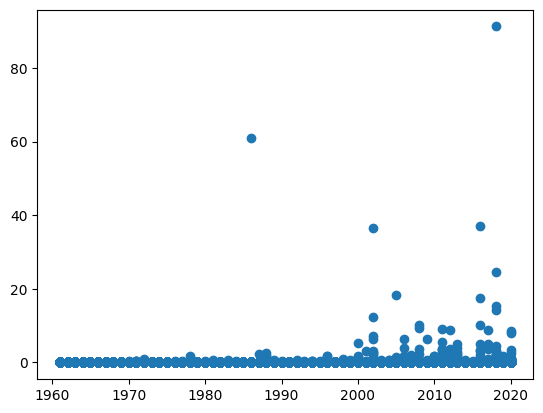

In [85]:
plt.scatter(x=close_wildfires_since1961["Fire_Year"], y=close_wildfires_since1961["smoke_intensity_est"])

## AQI Data

In [31]:
import json

gaseous_aqi_prefix = "../intermediate_data/gaseous_aqi_"
particulate_aqi_prefix = "../intermediate_data/particulate_aqi_"

START_YEAR = 1975
END_YEAR = 2023

aqi_data = []

years = range(START_YEAR, END_YEAR)

for year in years:
    
    gaseous_filename = gaseous_aqi_prefix + str(year) + ".json"
    print(gaseous_filename)
    
    with open(gaseous_filename, "r") as gaseous_file:
        gaseous_data = json.load(gaseous_file)
    
    for d in gaseous_data["Data"]:
        d["year"] = year
        aqi_data.append(d)
    
    particulate_filename = particulate_aqi_prefix + str(year) + ".json"
    print(particulate_filename)
    
    with open(particulate_filename, "r") as particulate_file:
        particulate_data = json.load(particulate_file)
    
    for d in particulate_data["Data"]:
        d["year"] = year
        aqi_data.append(d)

../intermediate_data/gaseous_aqi_1975.json
../intermediate_data/particulate_aqi_1975.json
../intermediate_data/gaseous_aqi_1976.json
../intermediate_data/particulate_aqi_1976.json
../intermediate_data/gaseous_aqi_1977.json
../intermediate_data/particulate_aqi_1977.json
../intermediate_data/gaseous_aqi_1978.json
../intermediate_data/particulate_aqi_1978.json
../intermediate_data/gaseous_aqi_1979.json
../intermediate_data/particulate_aqi_1979.json
../intermediate_data/gaseous_aqi_1980.json
../intermediate_data/particulate_aqi_1980.json
../intermediate_data/gaseous_aqi_1981.json
../intermediate_data/particulate_aqi_1981.json
../intermediate_data/gaseous_aqi_1982.json
../intermediate_data/particulate_aqi_1982.json
../intermediate_data/gaseous_aqi_1983.json
../intermediate_data/particulate_aqi_1983.json
../intermediate_data/gaseous_aqi_1984.json
../intermediate_data/particulate_aqi_1984.json
../intermediate_data/gaseous_aqi_1985.json
../intermediate_data/particulate_aqi_1985.json
../interme

In [32]:
len(aqi_data)

731656

In [33]:
import pandas as pd
aqi_df = pd.DataFrame(aqi_data)

In [34]:
set(aqi_df["parameter"])

{'Acceptable PM2.5 AQI & Speciation Mass',
 'Carbon monoxide',
 'Nitrogen dioxide (NO2)',
 'Ozone',
 'PM10 Total 0-10um STP',
 'PM2.5 - Local Conditions',
 'Sulfur dioxide'}

In [ ]:
aqd_df_ =

In [30]:
aqi_df_dedup.dtypes

state_code               object
county_code              object
site_number              object
parameter_code           object
poc                       int64
latitude                float64
longitude               float64
datum                    object
parameter                object
sample_duration_code     object
sample_duration          object
pollutant_standard       object
date_local               object
units_of_measure         object
event_type               object
observation_count         int64
observation_percent     float64
validity_indicator       object
arithmetic_mean         float64
first_max_value         float64
first_max_hour            int64
aqi                     float64
method_code              object
method                   object
local_site_name          object
site_address             object
state                    object
county                   object
city                     object
cbsa_code                object
cbsa                     object
date_of_

In [13]:
aqi_df_dedup = aqi_df.drop_duplicates()

In [19]:
index_columns = [i for i in aqi_df_dedup.columns if i != "aqi" and i != "parameter"]

In [26]:
import numpy as np